In [1]:
import argparse
import logging
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from lstchain.io import standard_config, replace_config, read_configuration_file
from lstchain.io.io import dl1_params_lstcam_key
from lstchain.reco import dl1_to_dl2
from lstchain.reco.utils import filter_events
from lstchain.visualization import plot_dl2
from lstchain.reco import utils
from lstchain.io import standard_config, replace_config, read_configuration_file
from lstchain.io.io import dl1_params_lstcam_key

import ctaplot
import astropy.units as u
import joblib

irf = ctaplot.irf_cta()

/home/david.miranda/.conda/envs/sipm_lstchain.0.6.3/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
config_file = '/fefs/aswg/workspace/david.miranda/data/prod5/dl2/lstchain_v.0.6.3/mono-lst-sipm-pmma-3ns/50.50/intensity_200_leakage_0.2/proton.json'
gammatest = '/fefs/aswg/workspace/david.miranda/data/prod5/dl1_merged/lstchain_v.0.6.3/mono-lst-sipm-pmma-3ns/50.50/dl1_gamma_on_merge_test.h5'
protontest = '/fefs/aswg/workspace/david.miranda/data/prod5/dl1_merged/lstchain_v.0.6.3/mono-lst-sipm-pmma-3ns/50.50/dl1_proton_merge_test.h5'

path_models = '/fefs/aswg/workspace/david.miranda/data/prod5/rf/lstchain_v.0.6.3/mono-lst-sipm-pmma-3ns/50.50/intensity_200_leakage_0.2/'

dl1_params_camera_key = 'dl1/event/telescope/parameters/LST_LSTCam'

output_dir = '/fefs/home/david.miranda/data/plots/'

In [3]:
custom_config = {}

if config_file is not None:
    try:
        custom_config = read_configuration_file(config_file)
    except("Custom configuration could not be loaded !!!"):
        pass
    
config = replace_config(standard_config, custom_config)

In [4]:
reg_energy = joblib.load(path_models + '/reg_energy.sav')
reg_disp_vector = joblib.load(path_models + '/reg_disp_vector.sav')
cls_gh = joblib.load(path_models + '/cls_gh.sav')

In [5]:
gammas = filter_events(pd.read_hdf(gammatest, key=dl1_params_camera_key),
                       config["events_filters"],
                       )
proton = filter_events(pd.read_hdf(protontest, key=dl1_params_camera_key),
                       config["events_filters"],
                       )

data = pd.concat([gammas, proton], ignore_index=True)

dl2 = dl1_to_dl2.apply_models(data, cls_gh, reg_energy, reg_disp_vector, custom_config=config)

/home/david.miranda/.conda/envs/sipm_lstchain.0.6.3/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:46: MissingFrameAttributeWarning: AltAz coordinate has no obstime, assuming same frame
  MissingFrameAttributeWarning,
/home/david.miranda/.conda/envs/sipm_lstchain.0.6.3/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:54: MissingFrameAttributeWarning: Horizontal coordinate has no location, assuming same frame
  MissingFrameAttributeWarning,


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
dl2.tail(20)

,intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,obs_id,event_id,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gammaness
499290,240.395652,2.380927,-0.423594,0.357423,0.554241,2.440717,0.087364,0.030572,-0.132714,-0.456125,2.236240,2.857123,25.727882,0.000000,0.000000,0.000000,0.000000,18,0.205475,0.427339,0.105150,1,5000,6390502,-1,0.168129,-0.774358,1.213598,3.154449,-75.795753,-15.579925,16328.945312,101,3.141593,1.22173,320.399994,36.813057,0.349942,1,-70.93,-52.07,43.0,0,0.196644,-0.231561,0.303791,-0.866762,1.0,-0.226951,0.125862,-1.276391,0.052919,0.033080,0.004846,-0.390514,0.362268,1.207562,3.178011,101,0.036667
499291,210.899290,2.324075,0.312818,0.445200,0.544112,0.958296,0.067595,0.043571,0.356520,0.419887,2.304357,0.345702,25.243860,0.000000,0.000000,0.000000,0.000000,19,0.324740,0.382954,0.136496,1,5000,6424209,-1,0.047506,-1.323254,1.250515,3.069488,-219.626541,71.322548,13251.358398,101,3.141593,1.22173,320.909088,193.226246,0.644590,1,-70.93,-52.07,43.0,0,0.514693,-1.080608,1.196922,-1.126288,1.0,0.827511,-0.635408,-1.181206,0.065886,-0.048969,-0.048103,0.263850,0.397097,1.230870,3.184138,101,0.016667
499292,20013.329595,4.301319,-0.828328,0.558592,0.999076,2.548282,0.454456,0.193689,0.951441,0.678861,3.223921,8.539392,29.843516,0.090818,0.198404,0.008138,0.016151,646,0.010343,0.361808,0.005546,5,5000,6576901,-1,18.299017,1.262428,1.178147,3.139032,71.179344,114.593597,21144.400391,101,3.141593,1.22173,324.045319,219.024703,0.426199,1,-70.93,-52.07,43.0,0,-0.391983,-0.586052,0.705059,0.981281,-1.0,-1.220311,-0.027460,1.021911,10.517465,-0.770260,-1.121077,-1.598587,-0.562485,1.164159,3.090867,101,0.136000
499293,207.344563,2.316693,-0.626878,0.057670,0.629525,3.049855,0.075322,0.043931,0.579147,0.474854,2.504668,-3.425127,25.889168,0.000000,0.000000,0.000000,0.000000,20,0.271096,0.390635,0.105731,1,5000,6706906,-1,0.062525,-1.203943,1.225553,3.169815,-440.568390,-317.665619,21491.007812,101,3.141593,1.22173,315.882355,455.163237,0.583241,1,-70.93,-52.07,43.0,0,0.737451,0.209733,0.766695,0.277087,1.0,0.110572,0.267403,-1.208059,0.061936,-0.049125,-0.031810,-0.676003,0.025860,1.197586,3.144125,101,0.251143
499294,503.986464,2.702419,-0.237789,0.605093,0.650139,1.945237,0.102193,0.080672,1.260893,0.485194,2.293919,-0.655842,25.692251,0.000000,0.000000,0.000000,0.000000,39,0.120914,0.354755,0.076770,1,5000,6756104,-1,0.404883,-0.392671,1.230863,3.171497,-97.384369,31.898687,29648.322266,101,3.141593,1.22173,302.916656,88.037344,0.789404,1,-70.93,-52.07,43.0,0,0.497420,-0.325938,0.594695,-0.580063,1.0,0.259630,0.279154,-0.936579,0.115723,-0.032332,-0.094852,-0.270121,0.510240,1.211639,3.193456,101,0.009333
499295,309.427622,2.490559,-0.406866,-0.019716,0.407344,-3.093173,0.135223,0.029811,-1.544909,-0.202399,1.876371,1.049582,25.134999,0.000000,0.000000,0.000000,0.000000,27,0.118971,0.332750,0.076064,1,5000,7234302,-1,0.233242,-0.632193,1.210924,3.126125,-129.355865,90.559219,23987.105469,101,3.141593,1.22173,250.000000,154.132008,0.220459,1,-70.93,-52.07,43.0,0,0.105382,-0.132809,0.169540,-0.900038,1.0,-0.301484,-0.152525,-1.190324,0.064517,-0.004737,-0.055658,-0.411604,-0.075373,1.207021,3.134028,101,0.149143
499296,228.327484,2.358558,-0.512501,-0.841696,0.985449,-2.117728,0.098392,0.049646,-0.892627,-0.274095,2.003608,-15.663462,26.468876,0.000000,0.000000,0.000000,0.000000,35,0.146499,0.284817,0.082652,2,5000,7984303,-1,1.235905,0.091985,1.218327,2.983604,-229.619904,174.571198,18412.648438

In [7]:
dl2.keys()

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'obs_id', 'event_id', 'calibration_id', 'mc_energy',
       'log_mc_energy', 'mc_alt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mc_h_first_int', 'mc_type', 'mc_az_tel', 'mc_alt_tel', 'mc_x_max',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'disp_dx', 'disp_dy', 'disp_norm',
       'disp_angle', 'disp_sign', 'src_x', 'src_y', 'log_reco_energy',
       'reco_energy', 'reco_disp_dx', 'reco_disp_dy', 'reco_src_x',
       'reco_src_y', 'reco_alt', 'reco_az', 'reco_type', 'gammaness'],
      dtype='object')

In [8]:
####PLOT SOME RESULTS#####

In [9]:
selected_gammas = dl2.query('reco_type==0 & mc_type==0')

if(len(selected_gammas) == 0):
    log.warning('No gammas selected, I will not plot any output') 
    sys.exit()

In [10]:
def plot_features(data, intensity_cut, leakage_cut, output_dir, true_particle=False):
    
    type_label = 'reco_type'
    if true_particle:
        type_label = 'mc_type'
    
    # Energy distribution
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['log_mc_energy'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['log_mc_energy'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"$log_{10}E$ [GeV]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_log_mc_energy.png', facecolor='white', dpi=600)
    plt.close(fig)
    
    # disp_ distribution
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['disp_norm'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['disp_norm'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"disp_norm [m]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_disp_norm.png', facecolor='white', dpi=600)
    plt.close(fig)
    
    # Intensity distribution LOG
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['log_intensity'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['log_intensity'], histtype=u'step', bins=100, label="p")
    ax.axvline(np.log10(intensity_cut), linestyle='dashed', color='tab:gray', label='cut : {} [pe]'.format(intensity_cut))
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"$log_{10}Intensity$ []")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_log_intensity.png', facecolor='white', dpi=600)
    plt.close(fig)
    
    dataforwl = data[data['log_intensity'] > np.log10(intensity_cut)]
    
    # Width distribution
    fig, ax = plt.subplots()
    ax.hist(dataforwl[dataforwl[type_label] == 0]['width'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(dataforwl[dataforwl[type_label] == 101]['width'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"Width [º]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_width.png', facecolor='white', dpi=600)
    plt.close(fig)

    # Length distribution
    fig, ax = plt.subplots()
    ax.hist(dataforwl[dataforwl[type_label] == 0]['length'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(dataforwl[dataforwl[type_label] == 101]['length'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"Length [º]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_length.png', facecolor='white', dpi=600)
    plt.close(fig)

    
    # r distribution
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['r'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['r'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"Radius to c.o.g [m]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_r.png', facecolor='white', dpi=600)
    plt.close(fig)


    # psi distribution
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['psi'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['psi'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"$\Psi$ [rad]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_psi.png', facecolor='white', dpi=600)
    plt.close(fig)

    # phi distribution
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['phi'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['phi'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"$\phi$ [rad]")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_phi.png', facecolor='white', dpi=600)
    plt.close(fig)

    # Time gradient
    fig, ax = plt.subplots()
    ax.hist(data[data[type_label] == 0]['time_gradient'], histtype=u'step', bins=100, label="$\gamma$")
    ax.hist(data[data[type_label] == 101]['time_gradient'], histtype=u'step', bins=100, label="p")
    ax.set_ylabel(r'Counts', fontsize=15)
    ax.set_xlabel(r"Time gradient []")
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir + '/feat_time_gradient.png', facecolor='white', dpi=600)
    plt.close(fig)

In [11]:
output_dir_reco='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/reco_type'
output_dir_mc='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/mc_type'
plot_features(data=dl2, intensity_cut=200, leakage_cut=0.2, output_dir=output_dir_reco, true_particle=False)
plot_features(data=dl2, intensity_cut=200, leakage_cut=0.2, output_dir=output_dir_mc, true_particle=True)

(<Figure size 864x576 with 4 Axes>,
 array([[<AxesSubplot:ylabel='$(\\Delta E/E)_{68}$'>,
         <AxesSubplot:xlabel='log(mc energy/[TeV])', ylabel='log(reco energy/[TeV])'>],
        [<AxesSubplot:xlabel='$E_R$ [TeV]', ylabel='Energy bias'>,
         <AxesSubplot:>]], dtype=object))

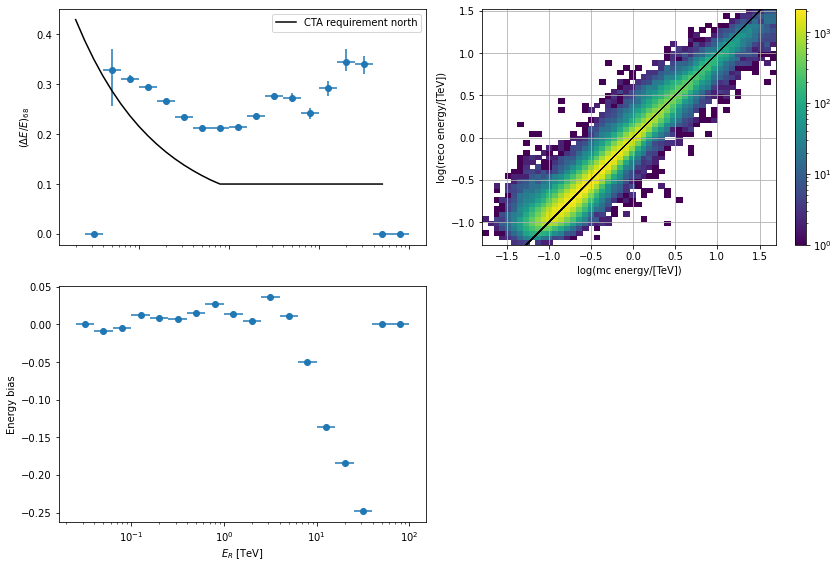

In [12]:
plot_dl2.energy_results(selected_gammas,
                        points_outfile='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/E_reso.h5',
                        plot_outfile='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/e_reso_all.png')

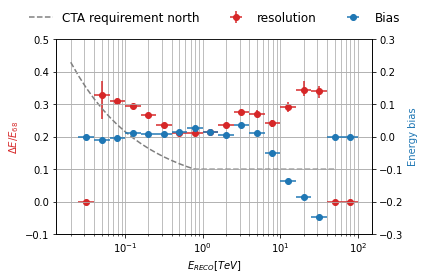

In [13]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
ctaplot.plot_energy_resolution(selected_gammas.mc_energy,
                               selected_gammas.reco_energy,
                               ax=ax0,
                               bias_correction=False,
                               color='tab:red',
                               label='resolution')

ctaplot.plot_energy_resolution_cta_requirement('north', ax=ax0, color='tab:gray', linestyle='dashed')
ctaplot.plot_energy_bias(selected_gammas.mc_energy,
                         selected_gammas.reco_energy,
                         ax=ax1,
                         label='Bias')

ax1.set_ylabel(r"Energy bias", color='tab:blue')
ax0.set_ylabel(r"${\Delta E/E}_{68}$",color='tab:red')
ax0.set_xlabel(r"$E_{RECO} [TeV]$")

ax0.set_title("")
ax1.set_title("")
ax0.set_ylim(-0.1, 0.5)
ax1.set_ylim(-0.3, 0.3)

ax0.get_legend().remove()
h0, l0 = ax0.get_legend_handles_labels()
h1, l1 = ax1.get_legend_handles_labels()
h = h0 + h1
l = l0 + l1
box=(0.5, 1.02)
ax0.legend(handles=h, loc="lower center", ncol=3,
           bbox_to_anchor=box, frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/e_reso_bias.png', facecolor='white', dpi=800)

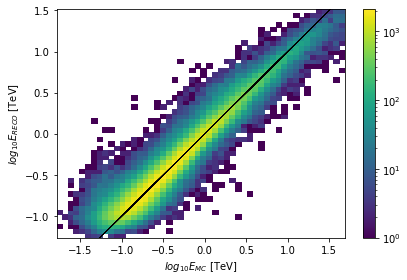

In [14]:
fig, ax = plt.subplots()
ax = ctaplot.plot_migration_matrix(selected_gammas.mc_energy.apply(np.log10),
                                   selected_gammas.reco_energy.apply(np.log10),
                                   colorbar=True,
                                   xy_line=True,
                                   hist2d_args=dict(norm=matplotlib.colors.LogNorm()),
                                   line_args=dict(color='black')
                                  )

ax.set_xlabel(r"$log_{10}E_{MC}$ [TeV]")
ax.set_ylabel(r"$log_{10}E_{RECO}$ [TeV]")
plt.tight_layout()
plt.savefig("/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/migration.png", facecolor='white', dpi=600)

(<Figure size 1080x864 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'angular resolution: 0.247(+1.5e-03/-1.4e-03)deg'}, xlabel='$\\theta^2 [deg^2]$', ylabel='Count'>,
         <AxesSubplot:title={'center':'Angular resolution'}, xlabel='$E_R$ [TeV]', ylabel='Angular Resolution [deg]'>],
        [<AxesSubplot:xlabel='simu alt [rad]', ylabel='reco alt [rad]'>,
         <AxesSubplot:xlabel='simu az [rad]', ylabel='reco az [rad]'>]],
       dtype=object))

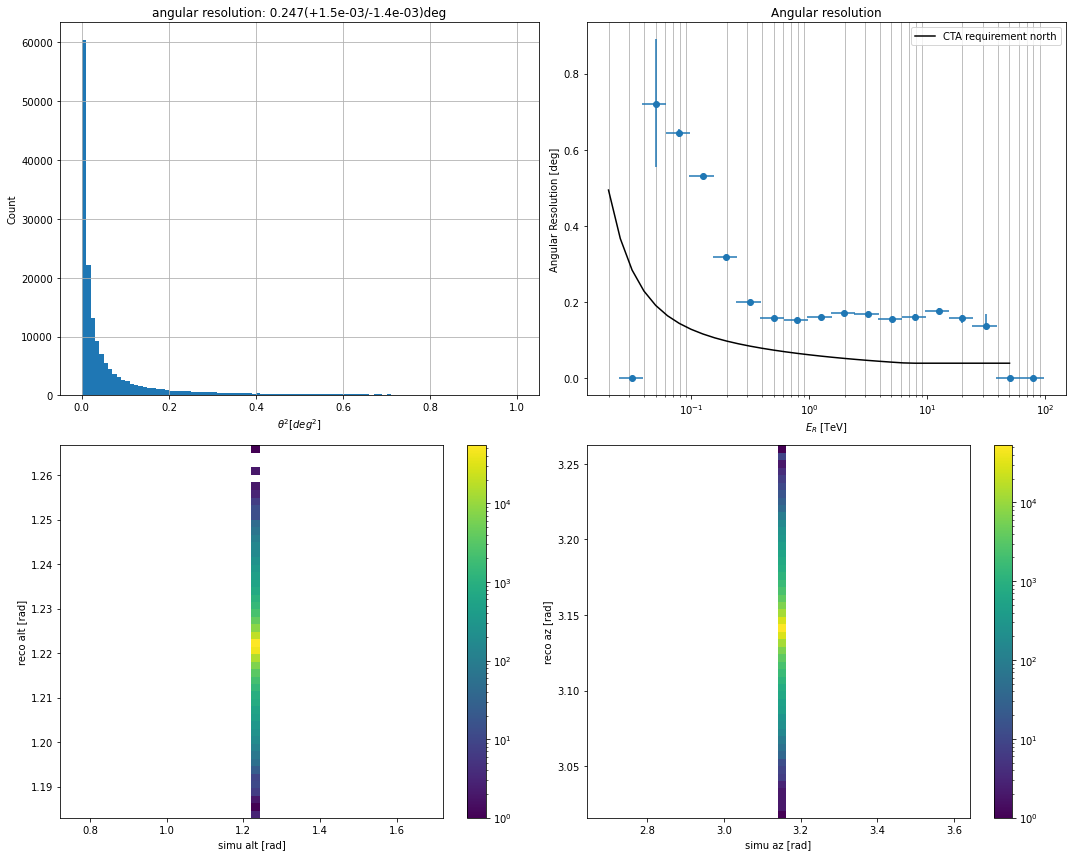

In [15]:
plot_dl2.direction_results(selected_gammas,
                           points_outfile='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/angular_resolution.h5',
                           plot_outfile='/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/angular_resolution_all.png')

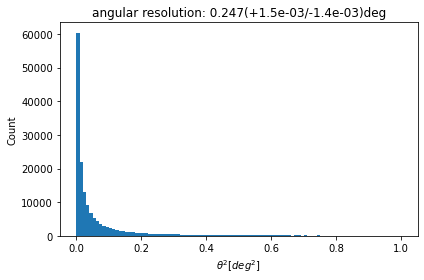

In [16]:
fig, ax = plt.subplots()
ctaplot.plot_theta2(selected_gammas.reco_alt,
                    selected_gammas.reco_az,
                    selected_gammas.mc_alt,
                    selected_gammas.mc_az,
                    ax=ax,
                    bins=100,
                    range=(0, 1)
                    )
plt.tight_layout()
plt.savefig("/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/theta2.png", facecolor='white', dpi=600)

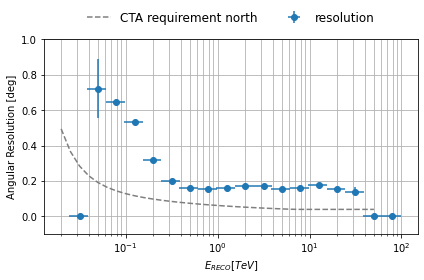

In [17]:
fig, ax = plt.subplots()

ctaplot.plot_angular_resolution_per_energy(selected_gammas.reco_alt,
                                           selected_gammas.reco_az,
                                           selected_gammas.mc_alt,
                                           selected_gammas.mc_az,
                                           selected_gammas.reco_energy,
                                           ax=ax,
                                           label='resolution'
                                           )

ctaplot.plot_angular_resolution_cta_requirement('north', ax=ax, color='tab:gray', linestyle='dashed')

ax.set_title("")
ax.set_ylim(-0.1, 1.0)
ax.set_xlabel(r"$E_{RECO} [TeV]$")

h, l = ax.get_legend_handles_labels()
box=(0.5, 1.02)
ax.legend(handles=h, loc="lower center", ncol=3,
           bbox_to_anchor=box, frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig("/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/angular_resolution.png", facecolor='white', dpi=600)

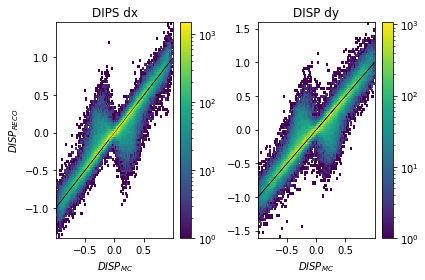

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ctaplot.plot_migration_matrix(selected_gammas.disp_dx,
                              selected_gammas.reco_disp_dx,
                              colorbar=True,
                              xy_line=True,
                              hist2d_args=dict(norm=matplotlib.colors.LogNorm(), bins=100),
                              line_args=dict(color='black'),
                              ax=ax0
                              )

ctaplot.plot_migration_matrix(selected_gammas.disp_dy,
                              selected_gammas.reco_disp_dy,
                              colorbar=True,
                              xy_line=True,
                              hist2d_args=dict(norm=matplotlib.colors.LogNorm(), bins=100),
                              line_args=dict(color='black'),
                              ax=ax1
                              )

ax0.set_xlabel('$DISP_{MC}$')
ax0.set_ylabel('$DISP_{RECO}$')
ax0.set_title('DIPS dx')

ax1.set_xlabel('$DISP_{MC}$')
ax1.set_title('DISP dy')
plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/disp_vector.png', facecolor='white', dpi=800)

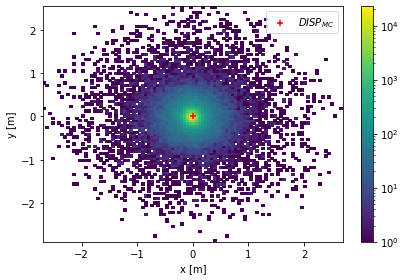

In [19]:
trueX = dl2[dl2['mc_type'] == 0]['src_x']
trueY = dl2[dl2['mc_type'] == 0]['src_y']

recoX = dl2[dl2['reco_type'] == 0]['reco_src_x']
recoY = dl2[dl2['reco_type'] == 0]['reco_src_y']

fig, ax = plt.subplots()

ctaplot.plot_migration_matrix(recoX,
                              recoY,
                              colorbar=True,
                              xy_line=False,
                              hist2d_args=dict(norm=matplotlib.colors.LogNorm(), bins=100),
                              line_args=dict(color='black'),
                              ax=ax
                              )

ax.scatter(np.mean(trueX), np.mean(trueY), color='red', marker='+', label='$DISP_{MC}$')

ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/disp_src.png', facecolor='white', dpi=600)

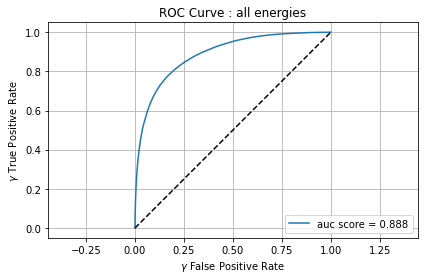

In [20]:
fig, ax = plt.subplots()
ctaplot.plot_roc_curve_gammaness(dl2.mc_type,
                                 dl2.gammaness,
                                 ax=ax
                                )

ax.set_title('ROC Curve : all energies')
ax.set_ylabel(r'$\gamma$ True Positive Rate')
ax.set_xlabel(r'$\gamma$ False Positive Rate')

plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/roc_all.png', facecolor='white', dpi=600)

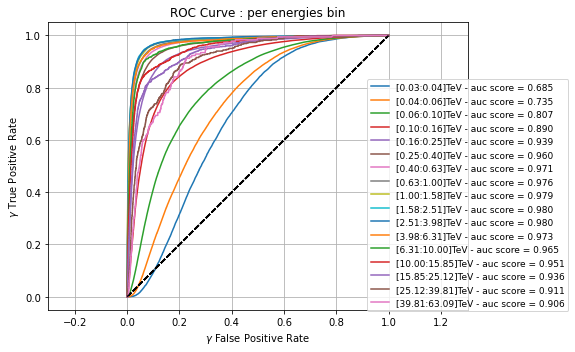

In [54]:
fig, ax = plt.subplots(figsize=(8, 5))
ctaplot.plot_roc_curve_gammaness_per_energy(dl2.mc_type,
                                            dl2.gammaness,
                                            dl2.mc_energy,
                                            ax=ax
                                            )


ax.set_xlim(-0.05, 1.05)
box=(0.5, 1.10)
ax.legend(loc="lower center", ncol=2, bbox_to_anchor=box, frameon=True, fontsize=10)

box=(0.75, 0.4)
ax.legend(loc="center left", ncol=1, bbox_to_anchor=box, frameon=True, fontsize=9)

ax.set_title('ROC Curve : per energies bin')
ax.set_ylabel(r'$\gamma$ True Positive Rate')
ax.set_xlabel(r'$\gamma$ False Positive Rate')

plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/roc_per_energy_bin.png', facecolor='white', dpi=600)

h, l = ax.get_legend_handles_labels()

In [22]:
irf = ctaplot.ana.irf_cta()
energy_bins = irf.E_bin

ebin_min = []
ebin_max = []
roc = []
for line in l:
    bins = line.split('= ')[0].replace("]TeV - auc score", "").replace("[","")
    
    ebin_min.append(float(bins.split(':')[0]))
    ebin_max.append(float(bins.split(':')[1]))
    roc.append(float(line.split('= ')[1]))

ebin_min = np.array(ebin_min)
ebin_max = np.array(ebin_max)
roc = np.array(roc)

roc = pd.DataFrame(
    {"ebin_min" : ebin_min,
     "ebin_max" : ebin_max,
     "mid_energy" : 0.5 * (ebin_min + ebin_max),
     "ebin_min_true": np.zeros_like(ebin_min),
     "ebin_max_true": np.zeros_like(ebin_max),
     "de_min": np.zeros_like(ebin_min),
     "de_max": np.zeros_like(ebin_max),
     "roc" : roc})

roc

for index, row in roc.iterrows():
    for j in range(len(energy_bins)-1):
        if (row.mid_energy <= energy_bins[j+1]) * (row.mid_energy > energy_bins[j]):
            print("{} < {} ≤ {}".format(energy_bins[j], row.mid_energy, energy_bins[j+1]))
            row['ebin_min_true'] = energy_bins[j]
            row['ebin_max_true'] = energy_bins[j+1]
            
            row['de_min'] = row['mid_energy'] - energy_bins[j]
            row['de_max'] = energy_bins[j+1] - row['mid_energy']

roc

errors = [roc['de_min'], roc['de_max']]

0.025100000000000004 < 0.035 ≤ 0.0397824795373728
0.0397824795373728 < 0.05 ≤ 0.06305361267495957
0.06305361267495957 < 0.08 ≤ 0.09993741258960195
0.09993741258960195 < 0.13 ≤ 0.15839673591090922
0.15839673591090922 < 0.20500000000000002 ≤ 0.251052386659856
0.251052386659856 < 0.325 ≤ 0.39790782609977393
0.39790782609977393 < 0.515 ≤ 0.6306677270746912
0.6306677270746912 < 0.815 ≤ 0.9995827070609686
0.9995827070609686 < 1.29 ≤ 1.5842979517754856
1.5842979517754856 < 2.045 ≤ 2.511047842534257
2.511047842534257 < 3.245 ≤ 3.979908741553117
3.979908741553117 < 5.145 ≤ 6.307993548663264
6.307993548663264 < 8.155 ≤ 9.997913317592669
9.997913317592669 < 12.925 ≤ 15.846286134404666
15.846286134404666 < 20.485 ≤ 25.11571927829913
25.11571927829913 < 32.465 ≤ 39.807393954395785
39.807393954395785 < 51.45 ≤ 63.09310101302338


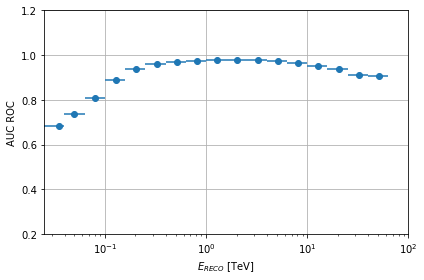

In [31]:
fig, ax = plt.subplots()

ax.errorbar(roc['mid_energy'], roc['roc'], xerr=errors, fmt='o')
ax.set_xscale('log')
ax.grid()
ax.set_xlim(energy_bins[0], energy_bins[-1])
ax.set_ylim(0.2, 1.2)
ax.set_ylabel('AUC ROC')
ax.set_xlabel('$E_{RECO}$ [TeV]')

plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/roc_per_energy_bin_2.png', facecolor='white', dpi=600)

In [24]:
config = read_configuration_file(config_file)
reg_features_names = config['regression_features']
clf_features_names = config['classification_features']

energy = joblib.load(os.path.join(path_models, "reg_energy.sav"))
disp = joblib.load(os.path.join(path_models, "reg_disp_vector.sav"))
clf = joblib.load(os.path.join(path_models, "cls_gh.sav"))

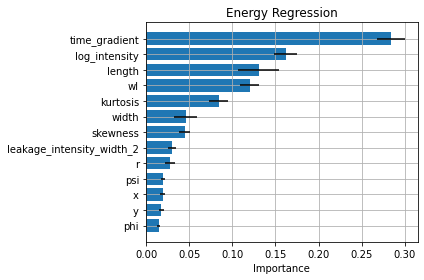

In [26]:
fig, ax = plt.subplots()
plot_dl2.plot_importances(energy, reg_features_names, ax=ax)
ax.set_title("Energy Regression")
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/energy_reg.png', facecolor='white', dpi=600)

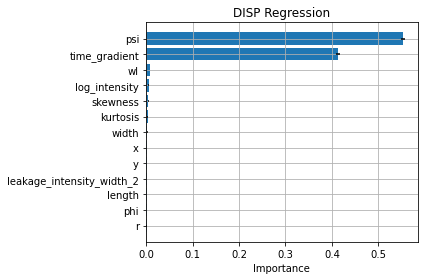

In [27]:
fig, ax = plt.subplots()
plot_dl2.plot_importances(disp, reg_features_names, ax=ax)
ax.set_title("DISP Regression")
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/disp_reg.png', facecolor='white', dpi=600)

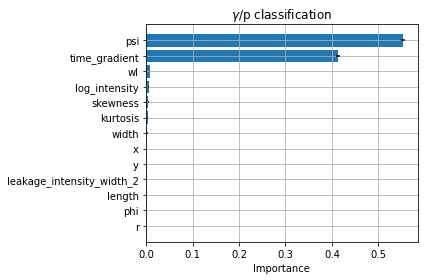

In [28]:
fig, ax = plt.subplots()
plot_dl2.plot_importances(disp, reg_features_names, ax=ax)
ax.set_title("$\gamma$/p classification")
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/gh_class.png', facecolor='white', dpi=600)

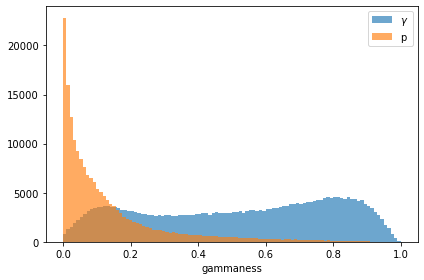

In [29]:
plt.hist(dl2[dl2['mc_type'] == 0]['gammaness'], bins=100, label='$\gamma$', alpha=0.65)
plt.hist(dl2[dl2['mc_type'] == 101]['gammaness'], bins=100, label='p', alpha=0.65)
plt.legend()
plt.xlabel('gammaness')
plt.tight_layout()
plt.savefig('/fefs/home/david.miranda/software/small_sipm_analysis/plots/dl2/gammaness.png', facecolor='white', dpi=600)